In [64]:
#PART 2


#Uusefull Functions from Part 1 of the Project
def calculate_spectrum(frame):
    fft_result = np.fft.fft(frame)
    power_spectrum = np.abs(fft_result[:N//2])**2
    PN = 90.302  
    power_spectrum_db = 10 * np.log10(power_spectrum) + PN
    return power_spectrum_db


def bark(frequencies):
    return 13 * np.arctan(0.00076 * frequencies) + 3.5 * np.arctan((frequencies / 7500) ** 2)



def sf(pm):
    sf = np.zeros((len(pm), len(pm)))
    for b in range(0, len(pm)):
        if pm[b] > 0:
            for a in range (0, len(pm)):
                diff = bark(a) - bark(b)
                if -3 <= diff < -1:
                    sf[a][b] = 17*diff - 0.4*pm[b] + 11
                if -1 <= diff < 0:
                    sf[a][b] = (0.4*pm[b] + 6)*diff
                if 0 <= diff < 1:
                    sf[a][b] = -17*diff
                if 1 <= diff < 8:
                    sf[a][b] = (0.15*pm[b] - 17)*diff -0.15*pm[b]
    return sf



def Tg(Tq, TTM, TNM):
    tg = np.zeros(len(Tq))
    for i in range (0, len(Tq)):
        tg[i] = 10 * np.log10(10**(0.1 * Tq[i]) + np.sum(10**(0.1 * TTM[i])) + np.sum(10**(0.1 * TNM[i])))
    return tg



def Tq(frame):
    tq = np.zeros(len(frame))
    for f in range(1, len(frame)): 
        tq[f] = 3.64 * (f / 1000) ** -0.8 - 6.5 * np.exp(-0.6 * (f / 1000 - 3.3) ** 2) + 10 ** -3 * (f / 1000) ** 4

    return tq


def ttm(sf, ptm):
    ttm = np.zeros((len(ptm), len(ptm)))
    
    for b in range(0, len(ptm)):
        for a in range (0, len(ptm)):
            ttm[a][b] = ptm[b] - 0.275*bark(b) + sf[a][b] - 6.025
    
    return ttm


def tnm(sf, pnm):
    tnm = np.zeros((len(pnm), len(pnm)))
    for b in range(0, len(pnm)):
        for a in range (0, len(pnm)):
            tnm[a][b] = pnm[b] - 0.175*bark(b) + sf[a][b] - 2.025
    
    return tnm

Analysis Filters:
[[ 0.00423054  0.01201259  0.01882773 ... -0.0241255  -0.01392593
  -0.00444348]
 [-0.00464571 -0.01553782 -0.02797726 ...  0.01240147  0.00983922
   0.00400742]
 [-0.00377463 -0.00745285 -0.00523189 ...  0.03015213  0.01681336
   0.00483675]
 ...
 [-0.00483675  0.01681336 -0.03015213 ... -0.00523189  0.00745285
  -0.00377463]
 [ 0.00400742 -0.00983922  0.01240147 ...  0.02797726 -0.01553782
   0.00464571]
 [ 0.00444348 -0.01392593  0.0241255  ...  0.01882773 -0.01201259
   0.00423054]]

Synthesis Filters:
[[ 0.          0.          0.         ...  0.01882773  0.01201259
   0.00423054]
 [ 0.          0.          0.         ... -0.02797726 -0.01553782
  -0.00464571]
 [ 0.          0.          0.         ... -0.00523189 -0.00745285
  -0.00377463]
 ...
 [ 0.          0.          0.         ... -0.03015213  0.01681336
  -0.00483675]
 [ 0.          0.          0.         ...  0.01240147 -0.00983922
   0.00400742]
 [ 0.          0.          0.         ...  0.0241255  -0.013

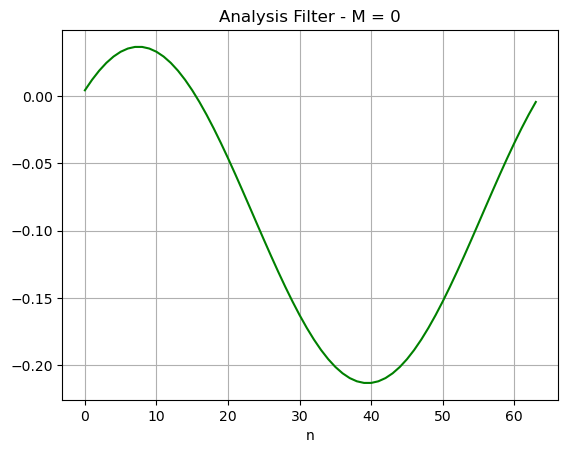

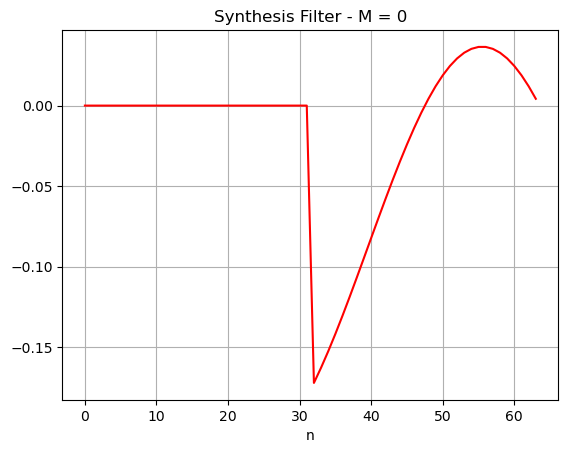

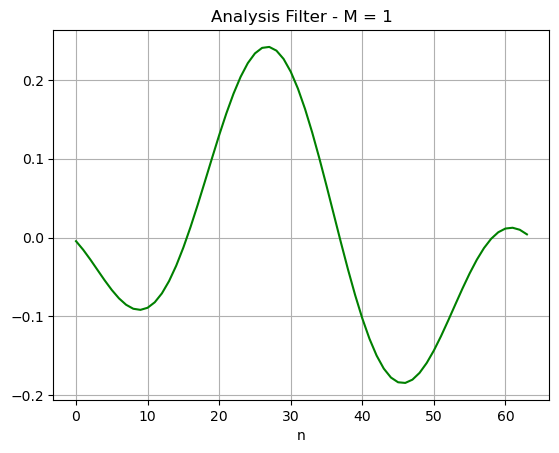

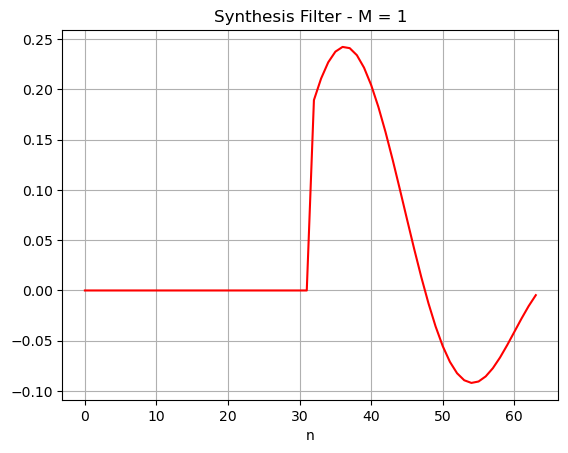

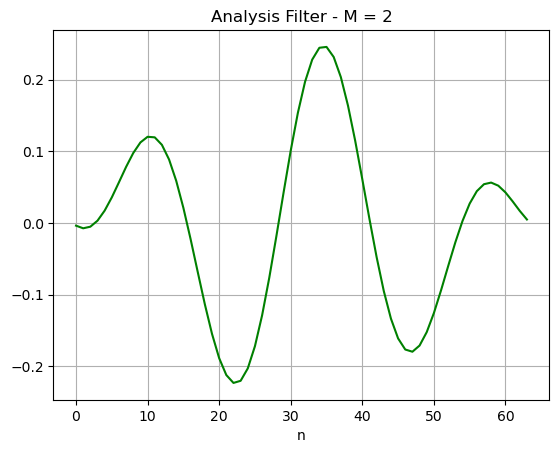

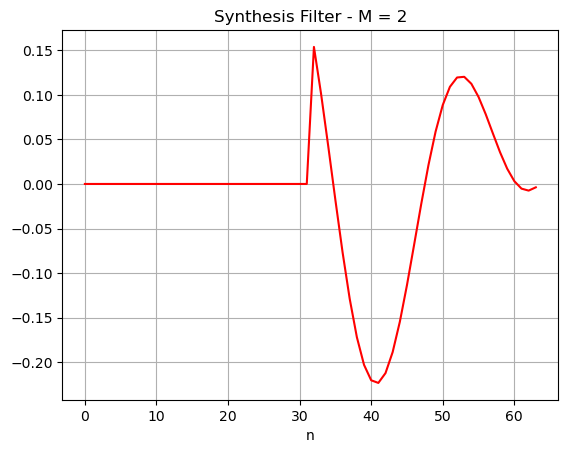

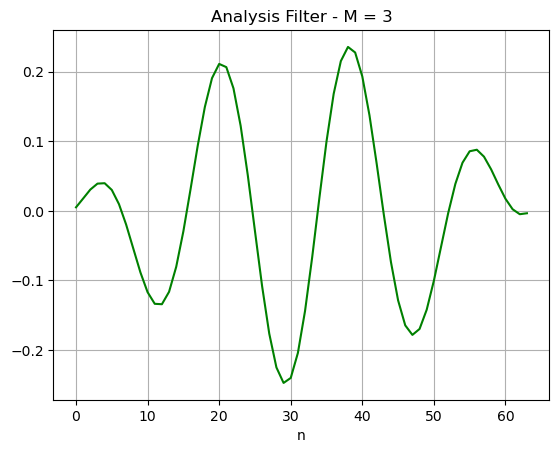

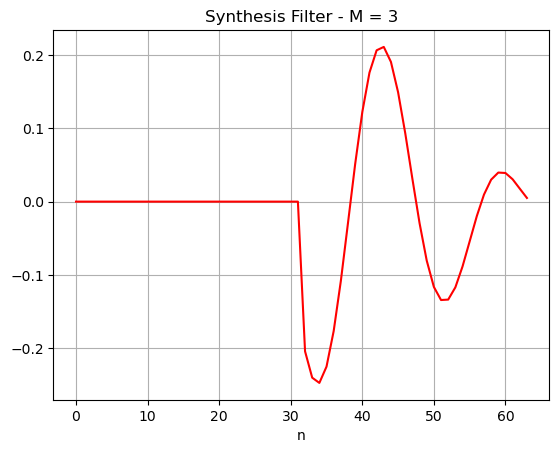

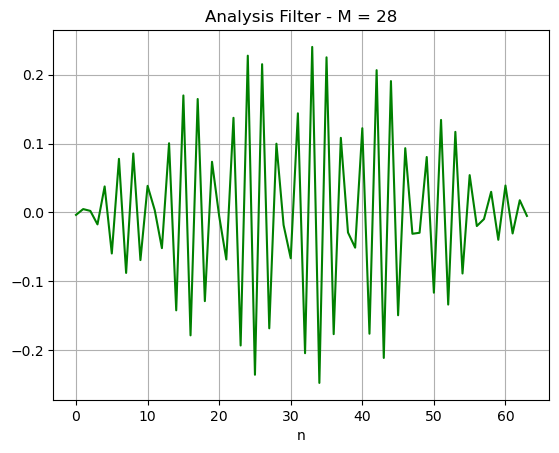

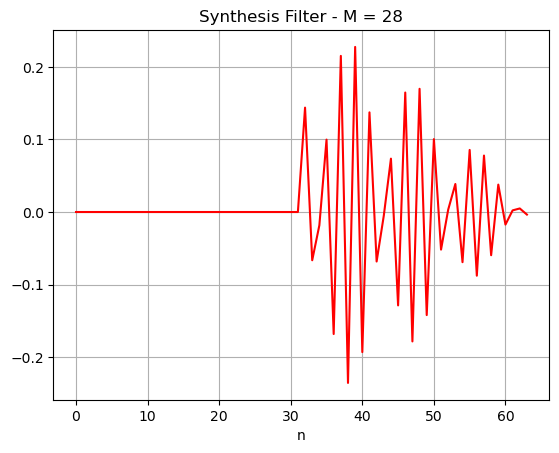

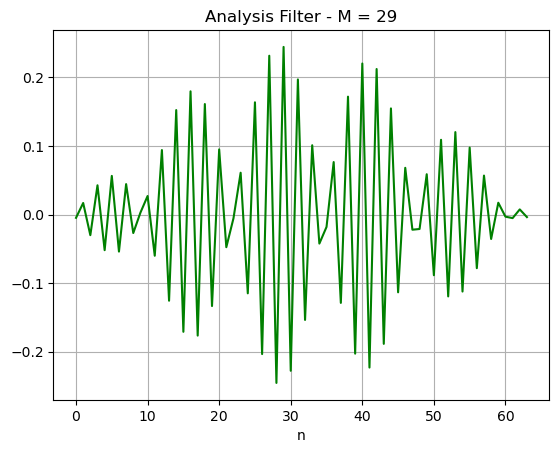

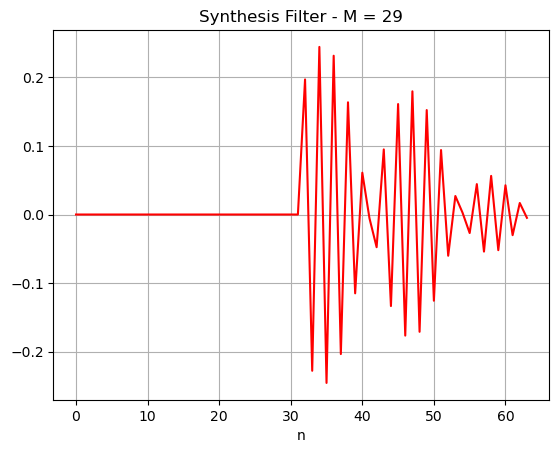

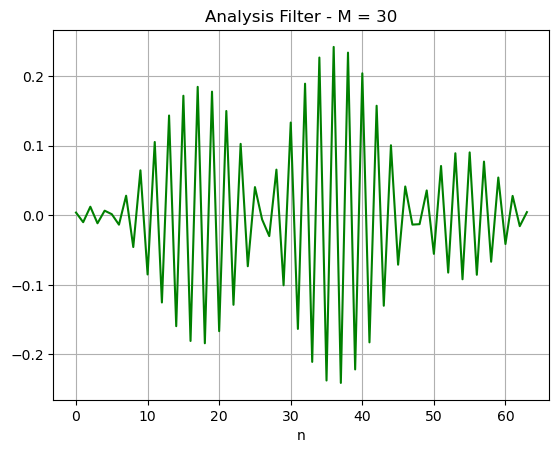

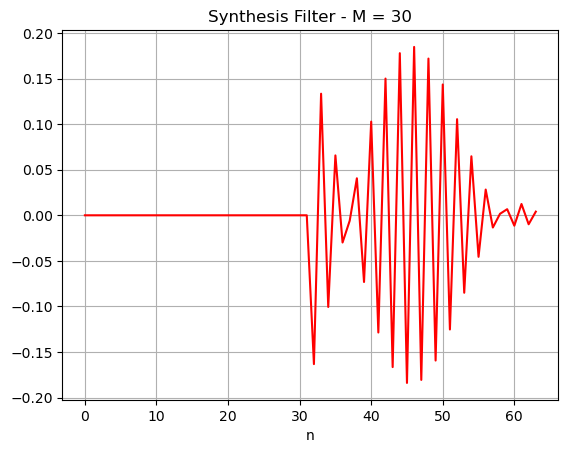

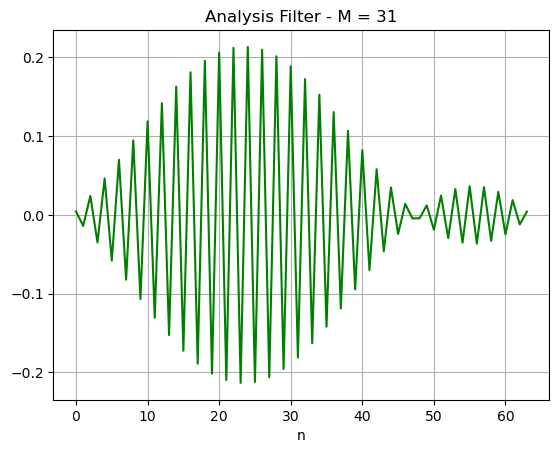

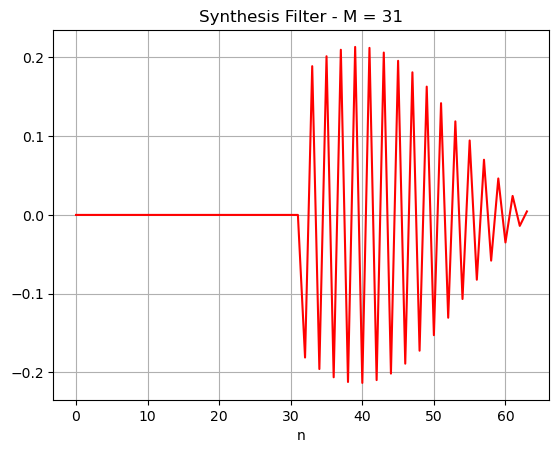

In [65]:
#2.0
import numpy as np
import matplotlib.pyplot as plt

#Function for filters creation
def filters(M):
    L = 2 * M
#2x2 matrix as we have two "variables", k and n with 0≤n≤L−1 and 0≤k≤M-1
    h = np.zeros((M, L))
    g = np.zeros((M, L))
    
#Filters creation    
    for k in range(M):
        for n in range(L):
            h[k, n] = np.sin(((n + 0.5) * np.pi / (2 * M))) * ((2/M)**0.5) * np.cos(((2 * n + M + 1) * (2 * k + 1) * np.pi) / (4 * M))
            g[k, n] = h[k, 2 * M - 1 - n]
    
    return h,g

#We use M=32 filters 
M=32
f_analysis, f_synthesis = filters(M)
print("Analysis Filters:")
print(f_analysis)
print("\nSynthesis Filters:")
print(f_synthesis)


#We plot the filters M=0,1,...3 and M=28,29,...31 

#M=0,1,...3
for k in range(4):
#Plotting the analysis filters
    plt.figure()
    plt.plot(f_analysis[k],color = 'green')
    plt.title(f"Analysis Filter - M = {k}")
    plt.xlabel('n')
    plt.grid(True)
#Plotting the synthesis filters
    plt.figure()
    plt.plot(f_synthesis[k],color = 'red')
    plt.title(f"Synthesis Filter - M = {k}")
    plt.xlabel('n')
    plt.grid(True)

#M=28,29,...31
for k in range(M-4, M):
    #Plotting the analysis filters
    plt.figure()
    plt.plot(f_analysis[k],color = 'green')
    plt.title(f"Analysis Filter - M = {k}")
    plt.xlabel('n')
    plt.grid(True)
#Plotting the synthesis filters
    plt.figure()
    plt.plot(f_synthesis[k],color = 'red')
    plt.title(f"Synthesis Filter - M = {k}")
    plt.xlabel('n')
    plt.grid(True)

In [66]:
#2.2

#Number of coding bits per y sample 
def Bk(Tg, B=16):
    R = 2**16
    Bk = int(np.log2(R / np.min(Tg)) - 1)
    
    return Bk


#Adaptive quantizer
def adaptive_quantizer(y, Tg):
    
    levels = 2**Bk(Tg,16)
#Step of quantization
    ymin = np.min(y)
    ymax = np.max(y)
    D = (ymax - ymin) / levels

#Quantization
    adaptive_quantizer_result = np.round(y / D) 
    
    return adaptive_quantizer_result


#Non adaptive quantizer
def non_adaptive_quantizer(y, B=8):

#Step of quantization
    D = 2 / (2**B) #xmax - xmin = 1 - (-1) = 2

#Quantization
    non_adaptive_quantizer_result = np.round(y / D)
    
    return non_adaptive_quantizer_result



In [67]:
#2.3

#Synthesis

def interpolation(quntized_signal):
    #quntized_signal = np.array(quntized_signal)
    
#Array with zeros
    w = np.zeros(len(quntized_signal) * 32)
    
#Interpolation -> Παρεμβάλουμε μηδενικά μετξύ των θέσεων 0,M,2M,...
    w[::32] = quntized_signal #Δηλαδή το w είναι ίδιο με το σήμα signal στις θέσεις 0,M,2M,... και αλλού μηδέν

    return w


In [68]:
#----- MAIN PROGRAM STARTS HERE ------#

import librosa
import numpy as np
import matplotlib.pyplot as plt


#Loading the .wav file
audio, fs = librosa.load('music_dsp2024.wav', sr=44100, mono=True)
audio = audio / np.max(np.abs(audio))


N=512
hop_length = 512

#Windowning the audio and taking 512 frames
frames = librosa.util.frame(audio, frame_length=N, hop_length=hop_length)
window = np.hanning(N)
windowed_frames = frames * window[:, np.newaxis]


#Plotting the first 5 frames
print(f"Length of each frame={len(windowed_frames[0])}")
for i in range(5): 
    print(f"Frame {i}:")
    print(windowed_frames[i])



Length of each frame=1416
Frame 0:
[-0. -0. -0. ... -0.  0. -0.]
Frame 1:
[-1.21434314e-07 -3.69348030e-06  2.58121242e-07 ... -2.99526235e-05
  1.18536319e-05 -7.80171451e-06]
Frame 2:
[-8.04838535e-07 -1.19857592e-05  9.72141696e-06 ... -1.28816409e-04
  4.19689301e-05 -2.40067157e-05]
Frame 3:
[-2.38620783e-06 -1.90632664e-05  3.44205200e-05 ... -2.85590012e-04
  5.98558068e-05 -4.93501535e-05]
Frame 4:
[-4.99252946e-06 -1.49212817e-05  6.80279048e-05 ... -4.70029737e-04
  7.91766334e-05 -8.74067991e-05]


In [116]:
PNM = np.load('P_NM-24.npy')
PNMc = np.load('P_NMc-24.npy')
PTMc = np.load('P_TMc-24.npy')


#Analysis and Synthesis Filters
h, g = filters(32)

final_adaptive = np.zeros(1417*639)
final_non_adaptive = np.zeros(1417*639)
bits_final_for_adaptive = 0
counter = 0


for frame1, frame2, frame3 in zip(PNMc.T, PTMc.T, windowed_frames.T):
    a = ttm(sf(frame1), frame1)
    b = tnm(sf(frame2), frame2)
    c = Tq(calculate_spectrum(frame3))
    d = Tg (c, a, b)

    
    bits_final_for_adaptive += Bk(d,16)
    
    final1 = np.zeros(639)
    final2 = np.zeros(639)


    for i, j in zip(h, g):
#Decimation and Convolution to get v
        v = np.convolve(i,frame3)
        v = v[::32]
       
#Quantizers
        adaptive_result = adaptive_quantizer(v, d)
        non_adaptive_result = non_adaptive_quantizer(v, 8)
    
        #adaptive_result = np.array(adaptive_result)
        #non_adaptive_result = np.array(non_adaptive_result)
        
#Interpolation
        w_adaptive = interpolation(adaptive_result)
        w_non_adaptive = interpolation(non_adaptive_result)
    
        x_hat_adaptive = np.convolve(w_adaptive,j)
        x_hat_non_adaptive = np.convolve(w_non_adaptive,j)
    
    
        final1 =np.add(final1, x_hat_adaptive ) 
        final2 = np.add(final2, x_hat_non_adaptive )
        
    final_adaptive[counter * 512: (counter + 1) * 512 + 127] += final1
    final_non_adaptive[counter * 512: (counter + 1) * 512 + 127] += final2
    counter = counter + 1


In [117]:
#Saving the signal in .wav

import sounddevice as sd
from scipy.io import wavfile

#Adaptive
normalised1 = np.int16((final_adaptive / final_adaptive.max()) * 32767)
wavfile.write('adaptive_quantizer.wav', 44100, normalised1)

#Non adaptive
normalised1 = np.int16((final_non_adaptive / final_non_adaptive.max()) * 32767)
wavfile.write('non_adaptive_quantizer.wav', 44100, normalised2)



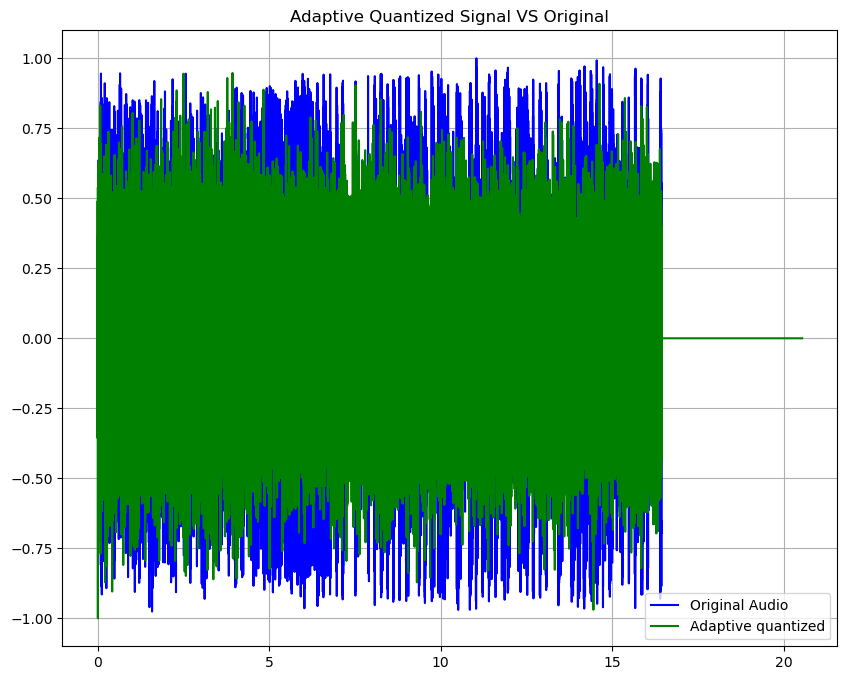

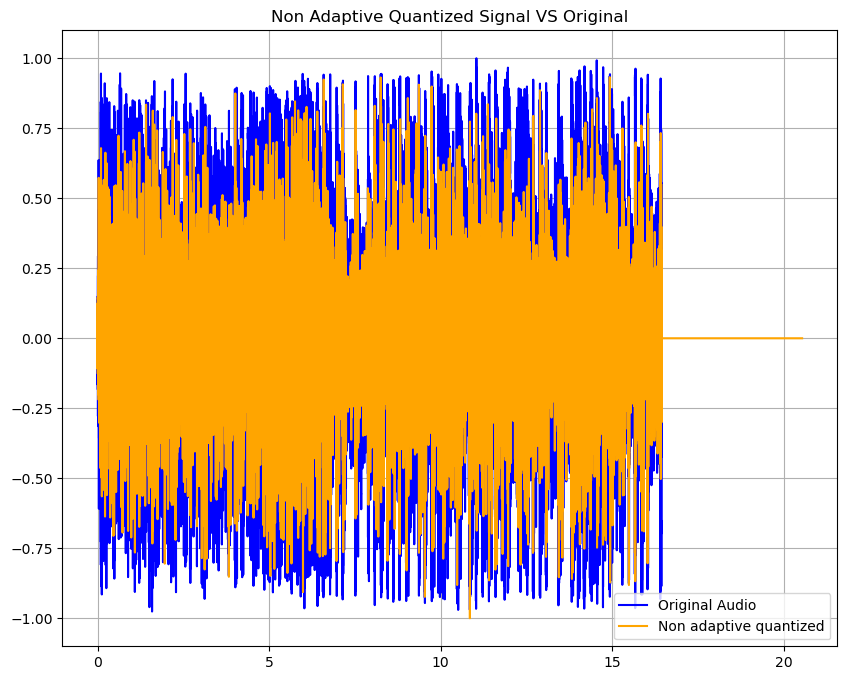

In [118]:
import matplotlib.pyplot as plt

#Plotting Adaptive Quantized Signal
final_adaptive_normalised = final_adaptive/np.max(np.abs(final_adaptive)) #Normalisation
plt.figure(figsize=(10,8))
plt.plot(np.arange(len(audio)) / fs,audio,color='blue',label='Original Audio')
plt.plot(np.arange(len(final_adaptive_normalised)) / fs,final_adaptive_normalised,color='green',label='Adaptive quantized')
plt.title('Adaptive Quantized Signal VS Original')
plt.grid(True)
plt.legend()



#Plotting Non Adaptive Quantized Signal
final_non_adaptive_normalised = final_non_adaptive/np.max(np.abs(final_non_adaptive)) #Normalisation
plt.figure(figsize=(10,8))
plt.plot(np.arange(len(audio)) / fs,audio,color='blue',label='Original Audio')
plt.plot(np.arange(len(final_non_adaptive_normalised)) / fs,final_non_adaptive_normalised,color='orange',label='Non adaptive quantized')
plt.title("Non Adaptive Quantized Signal VS Original")
plt.grid(True)
plt.legend()


In [136]:
#Errors
final_adaptive_normalised.resize(len(audio))
final_non_adaptive_normalised.resize(len(audio))
error_adaptive = audio - final_adaptive_normalised
error_non_adaptive = audio - final_non_adaptive_normalised



print("Mean Square Error - Adaptive Quantizer=", np.mean(np.square(error_adaptive)))
print("Mean Square Error -Non Adaptive Quantizer=", np.mean(np.square(error_non_adaptive)))

print("( ΠΡΟΦΑΝΩΣ ΚΑΠΟΙΟ ΛΑΘΟΣ ΤΟ ΟΠΟΙΟ ΔΕΝ ΕΝΤΟΠΙΣΤΗΚΕ ΜΑΣ ΕΒΓΑΛΕ ΠΕΡΙΠΟΥ ΙΔΙΑ ΣΦΑΛΜΑΤΑ ΣΤΟΥΣ 2 ΚΒΑΝΤΙΣΤΕΣ ΕΝΩ ΠΕΡΙΜΕΝΑΜΕ Ο ΠΡΟΣΑΡΜΟΖΟΜΕΝΟΣ ΝΑ ΒΓΑΛΕΙ ΜΙΚΡΟΤΕΡΟ)")


Mean Square Error - Adaptive Quantizer= 0.09412908116619181
Mean Square Error -Non Adaptive Quantizer= 0.09120078425211521
( ΠΡΟΦΑΝΩΣ ΚΑΠΟΙΟ ΛΑΘΟΣ ΤΟ ΟΠΟΙΟ ΔΕΝ ΕΝΤΟΠΙΣΤΗΚΕ ΜΑΣ ΕΒΓΑΛΕ ΠΕΡΙΠΟΥ ΙΔΙΑ ΣΦΑΛΜΑΤΑ ΣΤΟΥΣ 2 ΚΒΑΝΤΙΣΤΕΣ ΕΝΩ ΠΕΡΙΜΕΝΑΜΕ Ο ΠΡΟΣΑΡΜΟΖΟΜΕΝΟΣ ΝΑ ΒΓΑΛΕΙ ΜΙΚΡΟΤΕΡΟ)


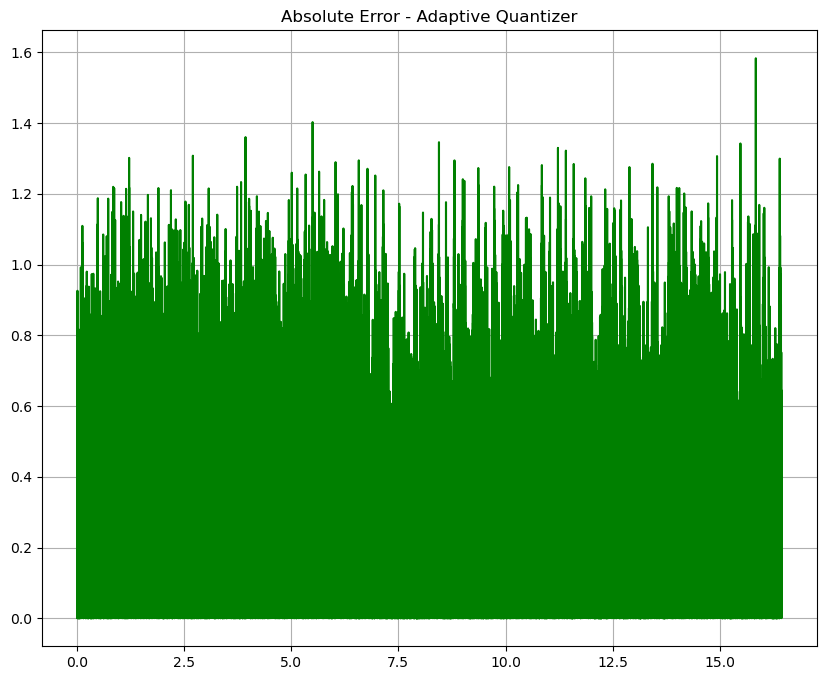

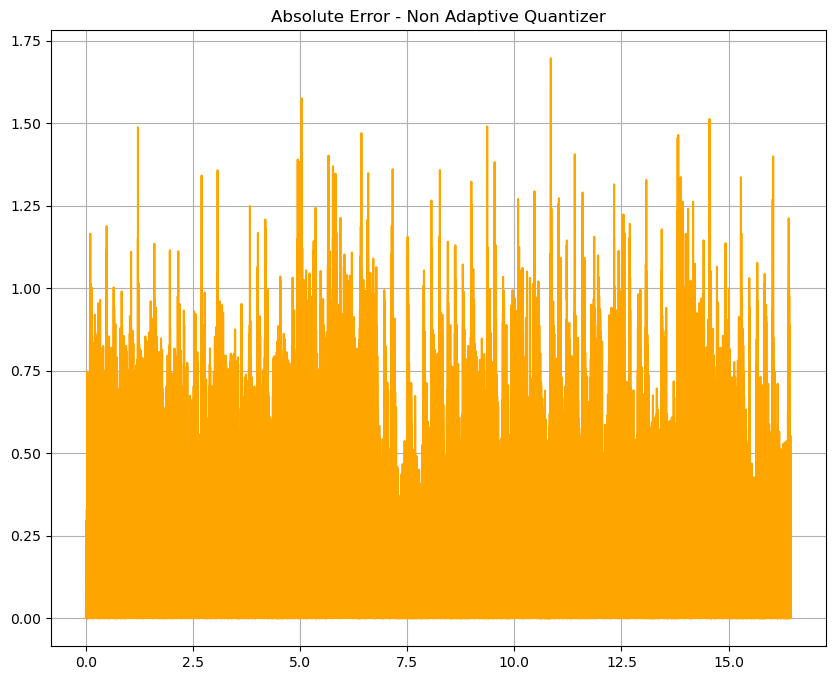

In [140]:
#Plotting the absolute errors

import matplotlib.pyplot as plt
import numpy as np

#Adaptive quantizer
absolute_error_adaptive = np.abs(error_adaptive)

plt.figure(figsize=(10, 8))
plt.plot(np.arange(len(error_adaptive)) / fs,absolute_error_adaptive,color='green')
plt.title("Absolute Error - Adaptive Quantizer")
plt.grid(True)
plt.show()

#Non adaptive quantizer
absolute_error_non_adaptive = np.abs(error_non_adaptive)

plt.figure(figsize=(10, 8))
plt.plot(np.arange(len(error_non_adaptive)) / fs,absolute_error_non_adaptive,color='orange')
plt.title("Absolute Error - Non Adaptive Quantizer")
plt.grid(True)
plt.show()



In [141]:
print("Final bits for adaptive quantizer = ",bits_final_for_adaptive,"bits")

Final bits for adaptive quantizer =  11328 bits
